In [1]:
%cd drive/MyDrive/Extract_text_project/

/content/drive/MyDrive/Extract_text_project


In [2]:
!pip install pytesseract
!sudo apt-get install tesseract-ocr
import pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 22 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 1s (3,571 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like

In [3]:
!pip install spacy
!python -m spacy download en
import spacy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-16 05:03:48.634579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 05:03:51.077399: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-16 05:03:51.077563: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could no

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
import numpy as np
import pandas as pd
import cv2
from glob import glob
import re
import string

In [5]:
def cleanText(txt):
  whitespace = string.whitespace
  punctuation = '!#$%&\'()*+:;<=>?[\\]^`{|}~'
  tableWhitespace = str.maketrans('', '', whitespace)
  tablePunctuation = str.maketrans('', '', punctuation)
  text = str(txt)
  text = text.lower()
  removewhitespace = text.translate(tableWhitespace)
  removepunctuation = removewhitespace.translate(tablePunctuation)

  return str(removepunctuation)

In [6]:
#### load NER model
model_ner = spacy.load('./output/model-best/')

In [7]:
from google.colab.patches import cv2_imshow

In [8]:
#Load Image
image = cv2.imread('./data/6.jpg')

# cv2_imshow(image)

#extract data using pytesseract
tessData = pytesseract.image_to_data(image)

#convert into dataframe
tesslist = list(map(lambda x:x.split('\t'), tessData.split('\n')))
df = pd.DataFrame(tesslist[1:], columns = tesslist[0])
df.dropna(inplace=True)
df['text'] = df['text'].apply(cleanText)

#convert data into content
df_clean = df.query('text != "" ')
content = " ".join([w for w in df_clean['text']])
print(content)

#get prediction from NER model
doc = model_ner(content)

cell 8099948528 te 8466045457 email lictsrikant@gmail.com life insurance corporation of india seosrikantht@gmail.com thathineni srikanth insurance advisor agent code no. 0316164y life insurance corporation of india br. off. lic office, trimulgherry, sec’bad - 500 016. add. borabanda, hyderabad - 500 018. lictsrikant8099948528.blogspot.in, interviewsinhyderabad.blogspot.in facebook.com/lictsrikant8099948528, facebook.com/thathineni.srikanth.9 promote your business online pybo


In [9]:
from spacy import displacy

In [10]:
from IPython.display import HTML

html = displacy.render(doc, style='ent', jupyter=True)
display(HTML(html))

<IPython.core.display.HTML object>

Tagging

In [11]:
docjson = doc.to_json()
docjson.keys()

dict_keys(['text', 'ents', 'tokens'])

In [12]:
doc_text = docjson['text']

In [13]:
datafram_tokens = pd.DataFrame(docjson['tokens'])
datafram_tokens['token'] = datafram_tokens[['start', 'end']].apply(lambda x: doc_text[x[0]:x[1]], axis=1) 
datafram_tokens.head(10)

,id,start,end,token
0,0,0,4,cell
1,1,5,15,8099948528
2,2,16,18,te
3,3,19,29,8466045457
4,4,30,35,email
5,5,36,57,lictsrikant@gmail.com
6,6,58,62,life
7,7,63,72,insurance
8,8,73,84,corporation
9,9,85,87,of


In [14]:
right_table = pd.DataFrame(docjson['ents'])[['start', 'label']]
datafram_tokens = pd.merge(datafram_tokens, right_table, how='left', on='start')

In [15]:
datafram_tokens.fillna('O', inplace=True)
datafram_tokens.head(10)

,id,start,end,token,label
0,0,0,4,cell,O
1,1,5,15,8099948528,B-PHONE
2,2,16,18,te,O
3,3,19,29,8466045457,O
4,4,30,35,email,O
5,5,36,57,lictsrikant@gmail.com,B-EMAIL
6,6,58,62,life,B-ORG
7,7,63,72,insurance,I-ORG
8,8,73,84,corporation,I-ORG
9,9,85,87,of,I-ORG


In [18]:
#join label to df_clean dataframe
df_clean['end'] = df_clean['text'].apply(lambda x: len(x) + 1).cumsum() - 1
df_clean['start'] = df_clean[['text', 'end']].apply(lambda x: x[1] - len(x[0]), axis = 1)

<ipython-input-18-a3ae132f2b62>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['end'] = df_clean['text'].apply(lambda x: len(x) + 1).cumsum() - 1
<ipython-input-18-a3ae132f2b62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['start'] = df_clean[['text', 'end']].apply(lambda x: x[1] - len(x[0]), axis = 1)


In [19]:
df_clean.head()

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,end,start
12,5,1,3,1,1,1,722,53,64,28,92,cell,4,0
14,5,1,3,1,1,3,822,53,203,28,96,8099948528,15,5
17,5,1,3,2,1,1,55,55,85,89,31,te,18,16
18,5,1,3,2,1,2,822,71,197,67,94,8466045457,29,19
20,5,1,3,2,2,1,593,136,93,25,89,email,35,30


In [20]:
#inner join with start
dataframe_info = pd.merge(df_clean, datafram_tokens[['start', 'token', 'label']], how='inner', on='start')

In [21]:
dataframe_info.tail()

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,end,start,token,label
44,5,1,6,3,4,1,46,571,106,21,96,promote,453,446,promote,O
45,5,1,6,3,4,2,161,576,56,22,96,your,458,454,your,O
46,5,1,6,3,4,3,226,571,111,21,96,business,467,459,business,O
47,5,1,6,3,4,4,347,571,74,21,92,online,474,468,online,O
48,5,1,6,3,4,5,432,571,96,27,92,pybo,479,475,pybo,O


Bounding Box

In [22]:
bb_df = dataframe_info.query("label != 'O'")

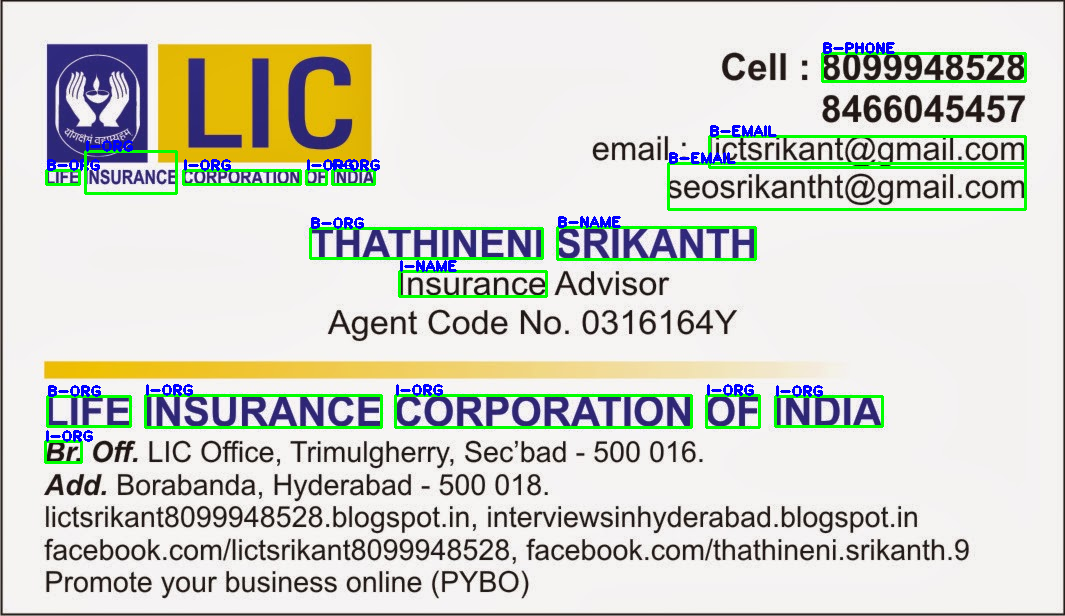

In [23]:
img = image.copy()
for x,y,w,h,label in bb_df[['left', 'top', 'width', 'height', 'label']].values:
  x = int(x)
  y = int(y)
  w = int(w)
  h = int(h)
  cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
  cv2.putText(img, str(label), (x,y), cv2.FONT_HERSHEY_PLAIN, 1, (255,0,0), 2)

cv2_imshow(img)

In [24]:
bb_df['label'] = bb_df['label'].apply(lambda x: x[2:])
bb_df.head()

<ipython-input-24-7f64f9e58c39>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_df['label'] = bb_df['label'].apply(lambda x: x[2:])


,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,end,start,token,label
1,5,1,3,1,1,3,822,53,203,28,96,8099948528,15,5,8099948528,PHONE
5,5,1,3,2,2,3,709,136,316,31,88,lictsrikant@gmail.com,57,36,lictsrikant@gmail.com,EMAIL
6,5,1,3,3,1,1,46,170,33,14,96,life,62,58,life,ORG
7,5,1,3,3,1,2,85,151,91,42,94,insurance,72,63,insurance,ORG
8,5,1,3,3,1,3,183,170,117,14,96,corporation,84,73,corporation,ORG


In [25]:
# group the label
class groupgen():
    def __init__(self):
        self.id = 0
        self.text = ''
        
    def getgroup(self,text):
        if self.text == text:
            return self.id
        else:
            self.id +=1
            self.text = text
            return self.id
        
grp_gen = groupgen()

In [26]:
# bb_df['group'] = bb_df['label'].apply(grp_gen.getgroup)
bb_df.loc[:, 'group'] = bb_df['label'].apply(grp_gen.getgroup)


<ipython-input-26-39b1bdf094f9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_df.loc[:, 'group'] = bb_df['label'].apply(grp_gen.getgroup)


In [27]:
# right and bottom of bounding box
bb_df[['left','top','width','height']] = bb_df[['left','top','width','height']].astype(int)
bb_df['right'] = bb_df['left'] + bb_df['width']
bb_df['bottom'] = bb_df['top'] + bb_df['height']

<ipython-input-27-00527f1b2ad2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_df[['left','top','width','height']] = bb_df[['left','top','width','height']].astype(int)
<ipython-input-27-00527f1b2ad2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_df['right'] = bb_df['left'] + bb_df['width']
<ipython-input-27-00527f1b2ad2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [28]:
# tagging: groupby group
col_group = ['left','top','right','bottom','label','token','group']
group_tag_img = bb_df[col_group].groupby(by='group')

In [29]:
img_tagging = group_tag_img.agg({
    
    'left':min,
    'right':max,
    'top':min,
    'bottom':max,
    'label':np.unique,
    'token':lambda x: " ".join(x)
    
})

In [30]:
img_tagging

,left,right,top,bottom,label,token
group,,,,,,
1,822,1025,53,81,[PHONE],8099948528
2,709,1025,136,167,[EMAIL],lictsrikant@gmail.com
3,46,374,151,193,[ORG],life insurance corporation of india
4,668,1025,163,209,[EMAIL],seosrikantht@gmail.com
5,310,542,228,258,[ORG],thathineni
6,399,755,227,296,[NAME],srikanth insurance
7,45,882,395,462,[ORG],life insurance corporation of india br


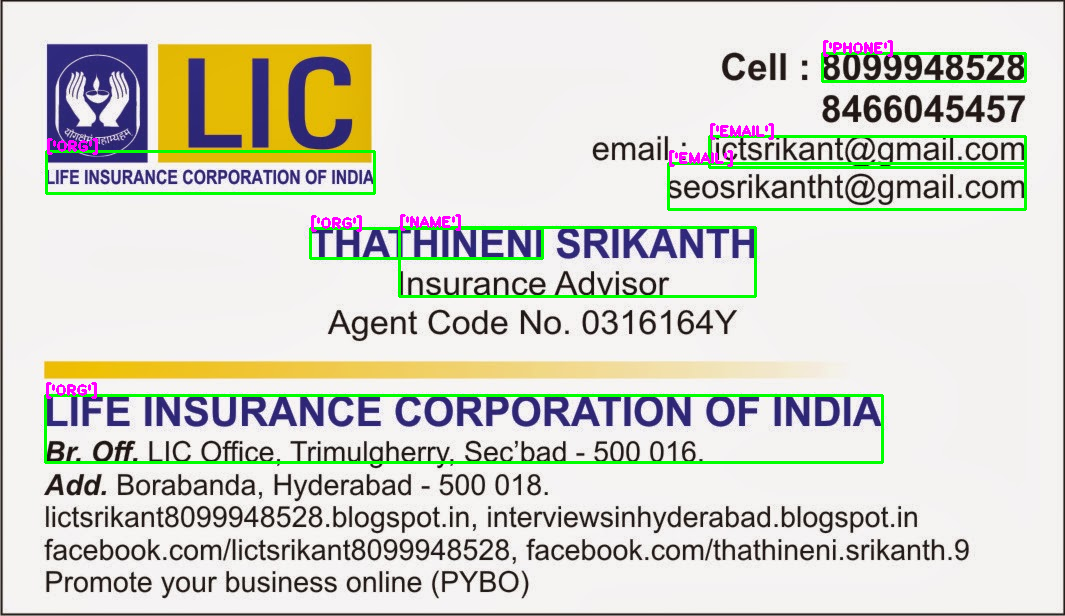

In [31]:
img_bb = image.copy()
for l,r,t,b,label,token in img_tagging.values:
    cv2.rectangle(img_bb,(l,t),(r,b),(0,255,0),2)
    
    cv2.putText(img_bb,str(label),(l,t),cv2.FONT_HERSHEY_PLAIN,1,(255,0,255),2)

cv2_imshow(img_bb)

Parser

In [ ]:
def parser(text,label):
    if label == 'PHONE':
        text = text.lower()
        text = re.sub(r'\D','',text)
        
    elif label == 'EMAIL':
        text = text.lower()
        allow_special_char = '@_.\-'
        text = re.sub(r'[^A-Za-z0-9{} ]'.format(allow_special_char),'',text)
        
    elif label == 'WEB':
        text = text.lower()
        allow_special_char = ':/.%#\-'
        text = re.sub(r'[^A-Za-z0-9{} ]'.format(allow_special_char),'',text)
        
    elif label in ('NAME', 'DES'):
        text = text.lower()
        text = re.sub(r'[^a-z ]','',text)
        text = text.title()
        
    elif label == 'ORG':
        text = text.lower()
        text = re.sub(r'[^a-z0-9 ]','',text)
        text = text.title()
        
    return text

Entities

In [ ]:
info_array = dataframe_info[['token','label']].values
entities = dict(NAME=[],ORG=[],DES=[],PHONE=[],EMAIL=[],WEB=[])
previous = 'O'

for token, label in info_array:
    bio_tag = label[0]
    label_tag = label[2:]
    
    # step -1 parse the token
    text = parser(token,label_tag)
    
    if bio_tag in ('B','I'):
        
        if previous != label_tag:
            entities[label_tag].append(text)
            
        else:
            if bio_tag == "B":
                entities[label_tag].append(text)
                
            else:
                if label_tag in ("NAME",'ORG','DES'):
                    entities[label_tag][-1] = entities[label_tag][-1] + " " + text
                    
                else:
                    entities[label_tag][-1] = entities[label_tag][-1] + text
                    
    
    
    previous = label_tag


In [ ]:
entities

{'NAME': ['Srikanth Insurance'],
 'ORG': ['Life Insurance Corporation Of India',
  'Thathineni',
  'Life Insurance Corporation Of India Br'],
 'DES': [],
 'PHONE': ['8099948528'],
 'EMAIL': ['lictsrikant@gmail.com', 'seosrikantht@gmail.com'],
 'WEB': []}